In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
np.set_printoptions(suppress=True)

In [7]:
path = '../AdhesionLoss'

data = get_data_in_directory(path)

print(len(data))

10


In [8]:
# use data_1 to do the pre-analyze
selected_id = 0
period = 140

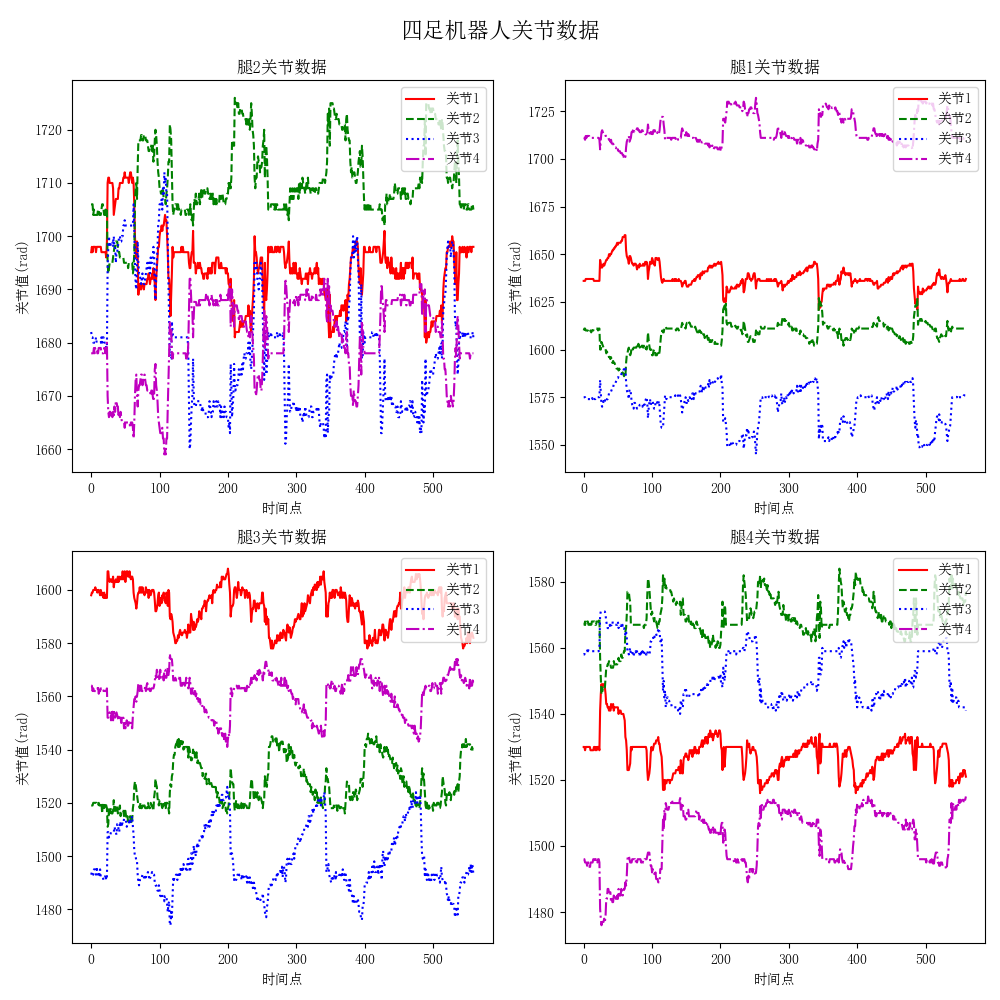

In [9]:
plot_leg_joints(data[9][:,32:48], joint_label='关节', title='四足机器人关节数据')

### Get the sample data

In [10]:
data_sample = []
for selected_id in np.arange(len(data)):
    print(selected_id)
    force_data_washed = force_washing(data[selected_id])
    Two_d_force = get_2d_force(force_data_washed)
    data_sample.append(np.hstack((force_data_washed[period*1:period*4,:32], Two_d_force[period*1:period*4,:])))
data_for_train = np.vstack(data_sample)
    

0
1
2
3
4
5
6
7
8
9


In [13]:
np.save('RF_limb.npy', data_for_train)

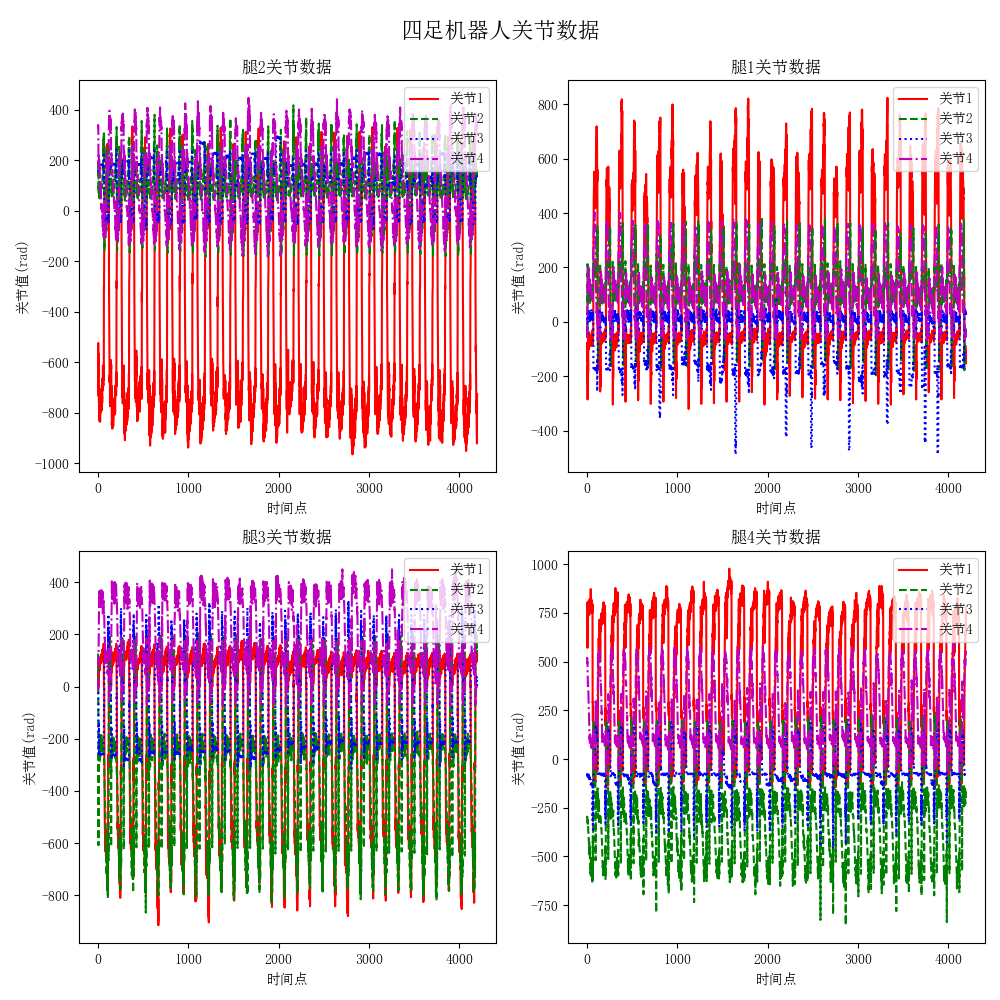

In [11]:
plot_leg_joints(data_for_train[:,16:32], joint_label='关节', title='四足机器人关节数据')

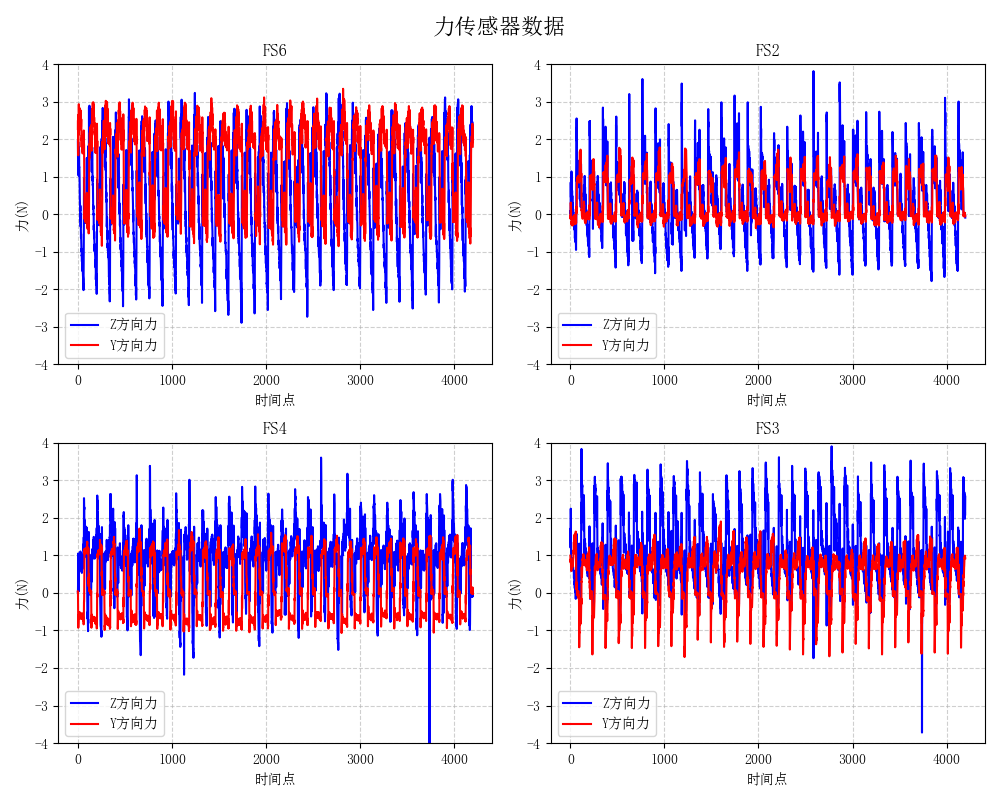

In [12]:
plot_force_sensors(data_for_train[:,32:], title='力传感器数据', save_path=None)

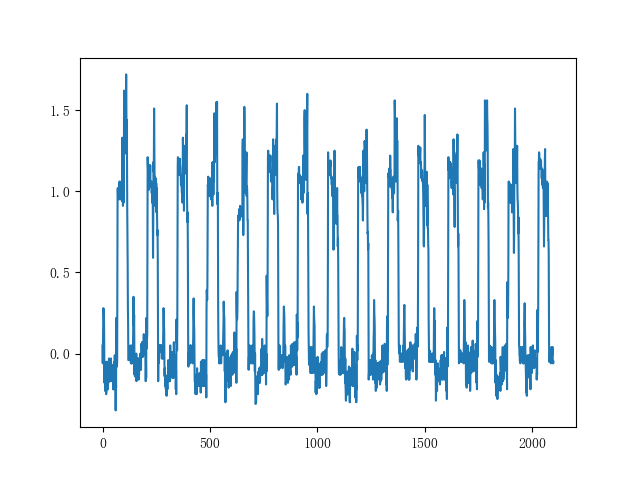

In [117]:
plt.close('all')
plt.plot(data_for_train[period*15:,33])
plt.show()

In [57]:
data_for_train.shape

(4200, 40)

In [58]:
period*6

840

In [3]:
def plot_force_sensors(data, title='力传感器数据', save_path=None):
    """
    绘制四个力传感器的Y/Z方向力学信号的2x2子图
    
    参数:
        data: numpy数组，形状为[n,16]，数据排列顺序为[FS6_Y, FS6_Z, FS2_Y, FS2_Z, FS4_Y, FS4_Z, FS3_Y, FS3_Z, ...]
        title: 图表标题 (默认: '力传感器数据')
        save_path: 图片保存路径 (可选)
    """
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['SimSun']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 检查数据形状
    if data.shape[1] != 8:
        raise ValueError("输入数据列数应为86 (4传感器×2方向)")
    
    # 创建2x2子图
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(title, fontsize=16)

    # 传感器配置 (名称, 子图位置, 数据列索引)
    sensor_config = [
        ('FS2', axs[0, 1], (0, 1)),   # 右上: FS2 (Y:0列, Z:1列)
        ('FS6', axs[0, 0], (2, 3)),   # 右上: FS6 (Y:2列, Z:3列)
        ('FS4', axs[1, 0], (4, 5)),   # 左下: FS4 (Y:4列, Z:5列)
        ('FS3', axs[1, 1], (6, 7))    # 右下: FS3 (Y:6列, Z:7列)
    ]

    # 绘制每个传感器的数据
    for name, ax, (y_col, z_col) in sensor_config:
        y_data = data[:, y_col]
        z_data = data[:, z_col]
        time = np.arange(len(y_data))
        
        ax.plot(time, y_data, 'b-', label='Z方向力')
        ax.plot(time, z_data, 'r-', label='Y方向力')
        ax.set_title(name)
        ax.set_xlabel('时间点')
        ax.set_ylabel('力(N)')
        ax.set_ylim(-4, 4)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # 保存或显示
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")
    
    plt.show()

In [4]:
'''读取并返回文件夹中的数据'''
def get_data_in_directory(path):
    data = []
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        
        # 这里注意需要把读入的数据进行翻转
        data.append(np.load(file_path).T)
    return data

In [5]:
def plot_leg_joints(data, joint_label='关节', title='四足机器人关节数据', save_path=None):
    """
    绘制四足机器人关节数据的2x2子图
    
    参数:
        data: numpy数组，形状为[n,16]，包含四个腿的关节数据
        joint_label: 关节标签名称 (默认: '关节')
        title: 图表标题 (默认: '四足机器人关节数据')
        save_path: 图片保存路径 (可选)，如'output.png'
    """
    # 设置中文字体为宋体
    plt.rcParams['font.sans-serif'] = ['SimSun']  # 或者使用 'STSong'
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 检查数据形状
    if data.shape[1] != 16:
        raise ValueError("输入数据的列数应为16 (4腿×4关节)")
    
    # 创建2x2的子图布局
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    # 定义每个腿的标签和颜色
    leg_names = ['腿1', '腿2', '腿3', '腿4']
    joint_names = [f'{joint_label}{i+1}' for i in range(4)]  # 使用输入的关节标签
    colors = ['r', 'g', 'b', 'm']  # 每种关节的颜色
    line_styles = ['-', '--', ':', '-.']  # 可选的线型

    # 绘制每个腿的数据
    for leg_idx in range(4):
        # 确定子图位置
        if leg_idx == 0:  # Leg1 -> (0,1)
            ax = axs[0, 1]
        elif leg_idx == 1:  # Leg2 -> (0,0)
            ax = axs[0, 0]
        elif leg_idx == 2:  # Leg3 -> (1,0)
            ax = axs[1, 0]
        else:  # Leg4 -> (1,1)
            ax = axs[1, 1]
        
        # 提取当前腿的数据 (4个关节)
        leg_data = data[:, leg_idx*4 : (leg_idx+1)*4]
        
        # 绘制每个关节的数据
        for joint_idx in range(4):
            ax.plot(leg_data[:, joint_idx], 
                    color=colors[joint_idx],
                    linestyle=line_styles[joint_idx],
                    linewidth=1.5,
                    label=joint_names[joint_idx])
        
        # 设置子图标题和标签
        ax.set_title(f'{leg_names[leg_idx]}{joint_label}数据')
        ax.set_xlabel('时间点')
        ax.set_ylabel(f'{joint_label}值(rad)')
        ax.legend(loc='upper right')
        # ax.grid(True, linestyle='--', alpha=0.6)

    # 调整子图间距
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

    # 保存或显示图形
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")
    plt.show()

In [6]:
def get_2d_force(data):
    forceReader = fm()
    force_test = np.zeros((force_data_washed.shape[0],2*4))
    # FS2 Y 
    for i in range(force_data_washed.shape[0]):
        force_test[i,:2]=forceReader.get_fs2(force_data_washed[i,32:35])[:2]
        force_test[i,2:4]=forceReader.get_fs6(force_data_washed[i,36:39])[:2]
        force_test[i,4:6]=forceReader.get_fs4(force_data_washed[i,40:43])[:2]
        force_test[i,6:8]=forceReader.get_fs3(force_data_washed[i,44:47])[:2]
        
    force_test[:,1] = -force_test[:,1]
    force_test[:,-1] = -force_test[:,-1]
    return force_test
def force_washing(data):
    data_swaped = swap_columns(data)
    for i in range(4):
        # force in leg 1 and 3
        if i % 2 == 0:
            data_swaped[:,32+4*i:36+4*i] -= calculate_column_averages(data_swaped[:,32+4*i:36+4*i],125,135)
        else:# force in leg 2 and 4
            data_swaped[:,32+4*i:36+4*i]-=calculate_column_averages(data_swaped[:,32+4*i:36+4*i],75,85 )
    return data_swaped
def calculate_column_averages(data, x, y):
    """
    计算(n,16)数据每行指定列从x到y的平均值，并返回这一组平均值(16,)
    
    参数:
    data -- 输入数据，形状为(n, 16)的numpy数组
    x -- 起始列索引(包含)
    y -- 结束列索引(包含)
    
    返回:
    形状为(16,)的numpy数组，包含每列从x到y行的平均值
    """
    # 确保x和y在有效范围内
    if x < 0 or y >= data.shape[0] or x > y:
        raise ValueError("无效的x或y值")
    
    # 提取从x到y的所有行
    selected_rows = data[x:y+1, :]
    
    # 计算每列的平均值
    column_averages = np.mean(selected_rows, axis=0)
    
    return column_averages
def swap_columns(data):
    """
    调换数据中[36:40]和[40:44]列的位置
    
    参数:
    data -- 输入数据，形状为(n, 54)的numpy数组
    
    返回:
    调换列后的新数组
    """
    # 创建数据的副本以避免修改原始数据
    swapped_data = data.copy()
    
    # 交换列[36:40]和[40:44]
    swapped_data[:, 36:40], swapped_data[:, 40:44] = data[:, 40:44], data[:, 36:40]
    
    return swapped_data